In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
ccdef = pd.read_csv('https://www.dropbox.com/s/qac84v449rjytv5/credit_default_model_data.csv?dl=1')


In [3]:
ccdef = ccdef.drop('Unnamed: 0', axis=1)
ccdef.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,pay_bucket_8_flag,pay_bucket_neg1_flag,pay_bucket_neg2_flag,pay_amt_total,bill_amt_total,pay_to_billed_ratio,zero_bill_amount,utilization_avg,utilization_max,default payment next month
0,20000,24,3913,3102,689,0,0,0,0,689,...,0,1,1,689,7704,0.089434,0,0.064200,0.195650,1
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,1,0,5000,17077,0.292791,0,0.023718,0.028792,1
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,0,11018,101653,0.108388,0,0.188246,0.324878,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,0,8388,231334,0.036259,0,0.771113,0.985820,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,1,0,59049,109339,0.540054,0,0.364463,0.716700,0


In [11]:
X = ccdef.iloc[:,0:54]
y = ccdef.iloc[:,55]
del ccdef

In [13]:
len(y)

30000

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20000, random_state=314)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=10000, random_state=314)

len(X_train), len(X_test), len(X_valid)

(10000, 10000, 10000)

In [19]:
boost = GradientBoostingClassifier()

param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [1, 3, 5], 'min_samples_leaf': [0.5, 1, 2], 'subsample': [0.25, 0.5, 1]}

boost_rs = RandomizedSearchCV(boost, param_grid, cv=3, verbose=2, n_iter=2, n_jobs=-1, random_state=314)

boost_rs.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   10.1s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.5s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [1, 3, 5], 'min_samples_leaf': [0.5, 1, 2], 'subsample': [0.25, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=314, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [20]:
boost_rs.best_params_

{'subsample': 1,
 'n_estimators': 200,
 'min_samples_leaf': 0.5,
 'max_depth': 1,
 'learning_rate': 0.05}

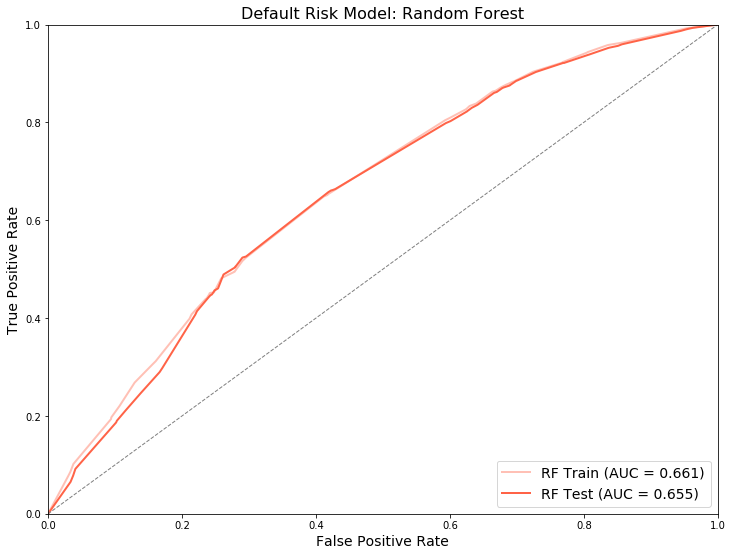

In [21]:
boost_scores_train = boost_rs.predict_proba(X_train)[:, 1]
boost_scores_test = boost_rs.predict_proba(X_test)[:, 1]

boost_fpr_train, boost_tpr_train, _ = roc_curve(y_train, boost_scores_train)
boost_fpr_test, boost_tpr_test, _ = roc_curve(y_test, boost_scores_test)

plt.figure().set_size_inches(12, 9)

plt.plot(boost_fpr_train, boost_tpr_train, color='tomato', lw=2, alpha = 0.4, linestyle = '-',
         label='RF Train (AUC = %0.3f)' %roc_auc_score(y_train, boost_scores_train))

plt.plot(boost_fpr_test, boost_tpr_test, color='tomato', lw=2, linestyle = '-',
         label='RF Test (AUC = %0.3f)' %roc_auc_score(y_test, boost_scores_test))


plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Random Forest', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
plt.show();